Etivity 4 - Yukti Patil 

# Import all Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_recall_fscore_support
from scipy import interp
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.neural_network import MLPClassifier

# Read Data and Exploratory Data Analysis

In [2]:
df = pd.read_csv("./seeds.csv")
df.head()

,area,perimeter,compactness,length of kernel,width of kernel,asymmetry coefficient,length of kernel groove,type
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1


### Check how many values are contained in each type. 
### The data has 3 classes of seeds

In [3]:
df['type'].value_counts()

3    70
2    70
1    70
Name: type, dtype: int64

### Check for missing values

In [4]:
df.isna().sum()

area                       0
perimeter                  0
compactness                0
length of kernel           0
width of kernel            0
asymmetry coefficient      0
length of kernel groove    0
type                       0
dtype: int64

### Draw a box plot to check for any outliers

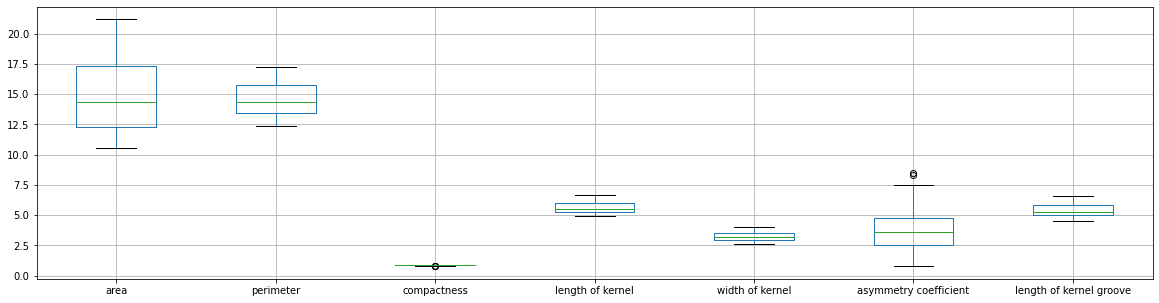

In [5]:
df.loc[:,'area':'length of kernel groove'].boxplot(figsize=(20,5))
plt.show()

### Taking a look at the Box Plot
### Looking at the box plot Compactness and Asymmetry_coefficient can be examined in detail. So we create box plots for them to single them out and check for outliers

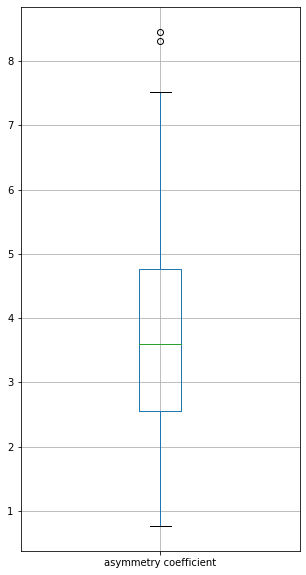

In [6]:
df.loc[:,'asymmetry coefficient':'asymmetry coefficient'].boxplot(figsize=(5,10))
plt.show()

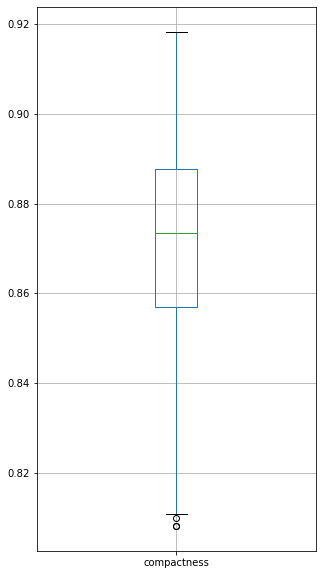

In [7]:
df.loc[:,'compactness':'compactness'].boxplot(figsize=(5,10))
plt.show()

### Observations
### The two columns Compactness and Asymmetry_coefficient do not seem to have very prominent outliers. However they are outlier columns. We will apply log transformation followed by **RobustScaler** to them. To all other predictor columns we will apply **StandardScaler**.  

# Data Preparation

### To do a binary classification on type, we need to reduce the three types down to two types.
### choosing to combine Kama and Rosa into one group.

In [8]:
mapper = {1: 0, 2: 0, 3: 1}
df['type'] = df['type'].replace(mapper)
df['type'].value_counts()

0    140
1     70
Name: type, dtype: int64

### Prepare two lists of column names. The list `names_outliers` contains the names of the three columns to which we will apply log transformation followed by `RobustScaler`. The list `names_no_outliers` contains the names of all other predictor columns to which we will apply `StandardScaler`.

In [9]:
# store a list with the names of all predictors
names_all = [c for c in df if c not in ['type']]

# define column groups with same data preparation
names_outliers = ['compactness', 'asymmetry coefficient']
names_no_outliers = list(set(names_all) - set(names_outliers))

### Transformation and Pipelining

In [10]:
class AddColumnNames(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return pd.DataFrame(data=X, columns=self.columns)

class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X[self.columns]

### Pipelines constructed for scaling , for performing parallel execution

In [11]:
preprocess_pipeline = make_pipeline(
    AddColumnNames(columns=names_all),
    FeatureUnion(transformer_list=[
        ("outlier_columns", make_pipeline(
            ColumnSelector(columns=names_outliers),
            FunctionTransformer(np.log, validate=True),
            RobustScaler()
        )),
        ("no_outlier_columns", make_pipeline(
            ColumnSelector(columns=names_no_outliers),
            StandardScaler()
        ))
    ])
)

### Split train and test data

In [12]:
y = df['type']
X = df.drop('type', axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y)

# Grid Search for best Classifiers

## SVM Classifier

In [16]:
from sklearn import set_config
from sklearn import svm
# Create the estimator
estimator_svm = svm.SVC(probability=True)
#print the estimator
set_config(print_changed_only=False)
print(estimator_svm)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)


### We can see all the hyperparameters to tune the Support Vector Machine Classifier. Upon trying various values for the hyperparameters, it was observed A higher C will cause the model to misclassify less, but is much more likely to cause overfit.
Using Additional parameter class_weight. This allows you to place greater emphasis on a class. For example, if the distribution between class 1 and class 2 is heavily imbalanced, the model can treat the two distributions appropriately.  “Balanced” will create class weights that are inversely proportional to class frequencies, giving more weight to individual occurrences of smaller classes.

In [17]:
# create the pipeline
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('svm', estimator_svm)])

# prepare a prameter grid
# note that __ can be used to specify the name of a parameter for a specific element in a pipeline
# note also that this is not an exhaustive list of the parameters of svn.SVC and their possible values

param_grid = {
    'svm__C': [0.1, 1, 10, 100,1000],  
    'svm__gamma': [1, 0.1, 0.01, 0.001], 
    'svm__kernel': ['rbf', 'linear', 'poly'],
    'svm__class_weight':["balanced"]}

search = GridSearchCV(pipe, param_grid, cv=10, iid=False, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
SVM_best_params = search.best_params_
SVM_best_model = search.best_estimator_

Best CV score = 0.970:
Best parameters:  {'svm__C': 0.1, 'svm__class_weight': 'balanced', 'svm__gamma': 1, 'svm__kernel': 'poly'}


/Users/yuktipatil/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


## Random Forest Classifier

In [18]:
#We find the hyperparameters for RF like we did for SVC
# Create the estimator
estimator_rf = RandomForestClassifier()
#print the estimator
print(estimator_rf)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


In [24]:

# create the pipeline
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('rf', estimator_rf)])

# prepare a prameter grid
# note that __ can be used to specify the name of a parameter for a specific element in a pipeline
# note also that this is not an exhaustive list of the parameters of RandomForestClassifier and their possible values
param_grid = {
    'rf__n_estimators' : [10,20,30,100],#500], #,800],
    'rf__max_depth': [2, 4, 6, 8,20,30],
    'rf__min_samples_leaf': [1,2,5,10],
    'rf__min_samples_split': [2,5,10,15,100]}
search = GridSearchCV(pipe, param_grid, cv=10, iid=False, refit=True, n_jobs=6)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)
search.score
# store the best params and best model for later use
RF_best_params = search.best_params_
RF_best_model = search.best_estimator_

Best CV score = 0.958:
Best parameters:  {'rf__max_depth': 4, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 10}


/Users/yuktipatil/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


## Conclusions:
### Using Different hyperparameters and tuning them, it was concluded that higher number of n_estimators played a role in achieving the best score for the model.  
### n_estimators - sets the number of decision trees to be used in the forest, it was observed increasing this values took a very long time for the Random forest to run.This is one of the limitation for Random Forest is that a large number of trees can make the algorithm too slow and ineffective for real-time predictions.
### max_depth  - Limiting the depth is good for pruning trees to prevent over-fitting on noisy data. If it is not set, the tree will keep expanding until all the leaves are pure.
### The minimum number of samples needed before a split (differentiation) is made in an internal node. Default is 2

# Looking at the Grid Search Output for Random Forest Classifier

In [25]:
gs=pd.DataFrame(search.cv_results_)
gs.head()


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_rf__max_depth,param_rf__min_samples_leaf,param_rf__min_samples_split,param_rf__n_estimators,params,split0_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.034730,0.004807,0.009921,0.001257,2,1,2,10,"{'rf__max_depth': 2, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 10}",1.0,...,0.882353,0.882353,0.941176,0.882353,1.000000,0.8125,0.8125,0.921324,0.073072,349
1,0.060515,0.004587,0.011631,0.001374,2,1,2,20,"{'rf__max_depth': 2, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 20}",1.0,...,0.823529,0.941176,1.000000,0.882353,0.941176,0.8125,0.8750,0.927574,0.070872,269
2,0.077656,0.005137,0.011489,0.001754,2,1,2,30,"{'rf__max_depth': 2, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 30}",1.0,...,0.882353,0.941176,0.941176,0.882353,0.941176,0.8125,0.8750,0.921691,0.055661,333
3,0.242533,0.008324,0.024070,0.002534,2,1,2,100,"{'rf__max_depth': 2, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 100}",1.0,...,0.823529,0.941176,0.941176,0.882353,0.941176,0.8750,0.8750,0.927941,0.058897,183
4,0.038051,0.004009,0.009561,0.001657,2,1,5,10,"{'rf__max_depth': 2, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 5, 'rf__n_estimators': 10}",1.0,...,0.823529,0.941176,0.941176,0.882353,0.941176,0.8125,0.8750,0.909926,0.062332,379


### We set the cross fold validation to 10; cv= 10, This means it ran 10 times and stored the average and standard deviation of the times it took in seconds.

### The "time" columns refer to the time it took to fit and score the model
### The param_ columns contain information on the different parameters that were used in the model. Each row in this Dataframe is equal to one model. i.e. Row 1 ran for 'rf__max_depth': 2, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 10
### The params column contains a dictionary of all the parameters

In [26]:
pd.set_option("display.max_colwidth",-1)  
#use set_option to not truncate the results to be printed
print(gs.loc[:,"params"])

0      {'rf__max_depth': 2, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 10}     
1      {'rf__max_depth': 2, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 20}     
2      {'rf__max_depth': 2, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 30}     
3      {'rf__max_depth': 2, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 100}    
4      {'rf__max_depth': 2, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 5, 'rf__n_estimators': 10}     
                                                      ...                                                      
475    {'rf__max_depth': 30, 'rf__min_samples_leaf': 10, 'rf__min_samples_split': 15, 'rf__n_estimators': 100} 
476    {'rf__max_depth': 30, 'rf__min_samples_leaf': 10, 'rf__min_samples_split': 100, 'rf__n_estimators': 10} 
477    {'rf__max_depth': 30, 'rf__min_samples_leaf': 10, 'rf__min_samples_split': 100, 'rf__n_estimators

<ipython-input-26-ee54e07ed1da>:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option("display.max_colwidth",-1)


### The test_score columns contain the scores on the test set for each of the cross-folds.

### The rank_column ranks the rows by the mean_test_score from best to worst.

### Using the rank_column (rank_test_score) we can easily get the best grid squares from the grid Search

In [27]:
best_row = gs[gs["rank_test_score"] == 1]
best_row

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_rf__max_depth,param_rf__min_samples_leaf,param_rf__min_samples_split,param_rf__n_estimators,params,split0_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
80,0.040246,0.003528,0.010187,0.001235,4,1,2,10,"{'rf__max_depth': 4, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 10}",1.0,...,0.882353,0.941176,0.941176,0.882353,1.0,1.0,0.9375,0.958456,0.046097,1


### The Grid Search CV gives out the best_estimator, best_params, best_score based on the best_index - which is the index that corresponds to the best candidate parameter setting.

In [28]:
print("Best Index  : " ,search.best_index_)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

Best Index  :  80
Best CV score = 0.958:
Best parameters:  {'rf__max_depth': 4, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 10}


# Use Another Classifier : MLP Classifier

### without any parameters -CV Score 0.952

In [29]:
#MLP Classifier - GridSearch 
# create the pipeline
pipe3 = Pipeline(steps=[('preprocess', preprocess_pipeline), ('mlp', MLPClassifier(max_iter=100))])

parameters = {}

search3 = GridSearchCV(pipe3, parameters, n_jobs=-1, cv=3)
search3.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search3.best_score_)
print("Best parameters: ", search3.best_params_)

Best CV score = 0.952:
Best parameters:  {}


/Users/yuktipatil/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


### with parameters - CV Score - 0.988

we can also set, n_jobs for grid search CV. We can set this by checking how many cores are available.

In [23]:
import os
os.cpu_count()

8

In [30]:
#MLP Classifier - GridSearch 
# create the pipeline
pipe3 = Pipeline(steps=[('preprocess', preprocess_pipeline), ('mlp', MLPClassifier(max_iter=100))])

parameters = {
    'mlp__solver': ['lbfgs'], 
    'mlp__max_iter': [1000,1100,1200,1300,1400,1500,1600,1700,1800,1900,2000 ], 
    'mlp__alpha': 10.0 ** -np.arange(1, 10), 
    'mlp__hidden_layer_sizes':np.arange(10, 15),
     'mlp__random_state':[0,1,2,3,4,5,6,7,8,9]}

search3 = GridSearchCV(pipe3, parameters, n_jobs=4, cv=3)
search3.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search3.best_score_)
print("Best parameters: ", search3.best_params_)

# store the best params and best model for later use
MLP_best_params = search3.best_params_
MLP_best_model = search3.best_estimator_

Best CV score = 0.988:
Best parameters:  {'mlp__alpha': 0.1, 'mlp__hidden_layer_sizes': 14, 'mlp__max_iter': 1000, 'mlp__random_state': 0, 'mlp__solver': 'lbfgs'}


## We see that having parameters and tuning the model, helps improving the score
### MLP has the best CV score when compared to Random forest and SVC

In [31]:
#Compare classifiers on test
mean_fpr = np.linspace(start=0, stop=1, num=100)

In [32]:
# model - a trained binary probabilistic classification model;
#         it is assumed that there are two classes: 0 and 1
#         and the classifier learns to predict probabilities for the examples to belong to class 1

def evaluate_model(X_test, y_test, model):
    # compute probabilistic predictiond for the evaluation set
    _probabilities = model.predict_proba(X_test)[:, 1]
    
    # compute exact predictiond for the evaluation set
    _predicted_values = model.predict(X_test)
        
    # compute accuracy
    _accuracy = accuracy_score(y_test, _predicted_values)
        
    # compute precision, recall and f1 score for class 1
    _precision, _recall, _f1_score, _ = precision_recall_fscore_support(y_test, _predicted_values, labels=[1])
    
    # compute fpr and tpr values for various thresholds 
    # by comparing the true target values to the predicted probabilities for class 1
    _fpr, _tpr, _ = roc_curve(y_test, _probabilities)
        
    # compute true positive rates for the values in the array mean_fpr
    _tpr_transformed = np.array([interp(mean_fpr, _fpr, _tpr)])
    
    # compute the area under the curve
    _auc = auc(_fpr, _tpr)
            
    return _accuracy, _precision[0], _recall[0], _f1_score[0], _tpr_transformed, _auc

In [33]:
SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score, SVM_tpr, SVM_auc = evaluate_model(X_test, y_test, SVM_best_model)
RF_accuracy, RF_precision, RF_recall, RF_f1_score, RF_tpr, RF_auc = evaluate_model(X_test, y_test, RF_best_model)
MLP_accuracy, MLP_precision, MLP_recall, MLP_f1_score,MLP_tpr, MLP_auc = evaluate_model(X_test, y_test, MLP_best_model)

<ipython-input-32-e712ba2ef97f>:23: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  _tpr_transformed = np.array([interp(mean_fpr, _fpr, _tpr)])
<ipython-input-32-e712ba2ef97f>:23: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  _tpr_transformed = np.array([interp(mean_fpr, _fpr, _tpr)])
<ipython-input-32-e712ba2ef97f>:23: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  _tpr_transformed = np.array([interp(mean_fpr, _fpr, _tpr)])


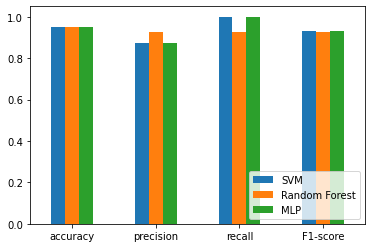

In [35]:
SVM_metrics = np.array([SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score])
RF_metrics = np.array([RF_accuracy, RF_precision, RF_recall, RF_f1_score])
mlp_metrics = np.array([MLP_accuracy, MLP_precision, MLP_recall, MLP_f1_score])
index = ['accuracy', 'precision', 'recall', 'F1-score']
df_metrics = pd.DataFrame({'SVM': SVM_metrics, 'Random Forest': RF_metrics,'MLP':mlp_metrics}, index=index)
df_metrics.plot.bar(rot=0)
plt.legend(loc="lower right")
plt.show()

# Analysis

SVC performs slightly better than Random Forest. Accuracy of SVC is higher. Recall and Precision are higher too in SVC. So the percentage of correct detection and class being identified correctly is higher in SVM.
Used the MLP classifier
MLP is a neural network classifier, it requires more data to be highly effective. But the goal here it to create a prediction model and compare it with different classifiers without much caring for the variables. So used the MLP classifier
SVC and MLP have the same recall,precision and accuracy.

Do the ROC curves help in picking the best classifier in this case?
ROC curves show SVC and MLP perform better than Random forest. Boith SVC and MLP give a curve closer to the 45 degree diagonal.

# Examine the ROC curves of the two classifiers

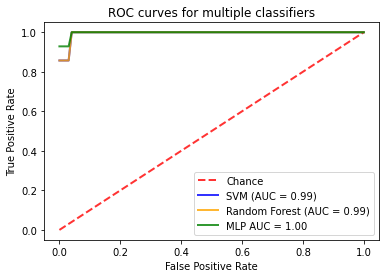

In [37]:
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=0.8)
plt.plot(mean_fpr, SVM_tpr[0,:], lw=2, color='blue', label='SVM (AUC = %0.2f)' % (SVM_auc), alpha=0.8)
plt.plot(mean_fpr, RF_tpr[0,:], lw=2, color='orange', label='Random Forest (AUC = %0.2f)' % (RF_auc), alpha=0.8)
plt.plot(mean_fpr, MLP_tpr[0,:],lw=2,color='green', label = 'MLP AUC = %0.2f' % (MLP_auc),alpha=0.8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves for multiple classifiers')
plt.legend(loc="lower right")
plt.show()

Finally, we can train an SVM model or MLP with all data we have, assuming that the more data we have the better the model.

In [39]:
# function to remove the string 'svm__' from the names of the parameters in SVM_best_params
def transform(dict):
    return {key.replace('svm__','') :  value for key, value in dict.items()}

pipe = make_pipeline(preprocess_pipeline, svm.SVC(**transform(SVM_best_params)))

final_model1 =pipe.fit(X, y)

In [40]:
# function to remove the string 'mlp__' from the names of the parameters in SVM_best_params

def transform(dict):
    return {key.replace('mlp__','') :  value for key, value in dict.items()}

pipe = make_pipeline(preprocess_pipeline, MLPClassifier(**transform(MLP_best_params)))

final_model2 =pipe.fit(X, y)